<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic comments classification**
![](https://techcrunch.com/wp-content/uploads/2013/06/hatespeech-tilt.jpg?w=200&crop=1)

Terms:
* NLP: **N**atural **L**anguage **P**rocessing 
* tokens: terms or words,
* tokenize = splitting a comment into the component words
* corpus: a collection of documents/sentence
* NLTK: **N**atural **L**anguage **T**ool**k**it

Assumptions:
* Which word embedding methodology to use? BOW (Bag Of Word),Word2Vec,Doc2Vec,  FastText,TFIDF 
* Word2Vec: use a trained model instead of training on this limied dataset.
* Strategy\plan how to clean the vocabulary
* Derive direct feaures from the text
* Classification of 6 categories

Pre-processing:
* Convert comments strings to lowercase
* decide if to replace \n by space or period
* remove words that have numbers inside them
* remove any other non letter charachter

Text clean:
* Multiple spaces
* Usernames
* email addresses
* '=', '-',
* IP addresses
* DateTime
* Comments that are less than 4 charachters
* Names (words that start with capital at middle of sentence)




In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import scipy
from scipy import stats
import re
import sys
import tensorflow as tf
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding; to visualize high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud, STOPWORDS
! pip install nltk
import nltk #natural language tool kit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
!pip install replacer #replace with regex

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For the dimensionality reduction
from sklearn.feature_selection import SelectKBest , f_classif

# essential tools for lsa
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
#other imports
from os import listdir

# For the tree models
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Get the data

In [132]:
traincomments=pd.read_csv('train10000 (1).csv')
# traincomments.head()
traincomments.info()
# traincomments.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10000 non-null  object
 1   comment_text   10000 non-null  object
 2   toxic          10000 non-null  int64 
 3   severe_toxic   10000 non-null  int64 
 4   obscene        10000 non-null  int64 
 5   threat         10000 non-null  int64 
 6   insult         10000 non-null  int64 
 7   identity_hate  10000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 625.1+ KB


Add columns

In [0]:
traincomments['number_categories']= traincomments.iloc[:, 2:8].sum(axis=1) # categories count
traincomments['any_category']= traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].max(axis=1)
traincomments['exclamation_mark_count']=traincomments['comment_text'].str.count('!') # count '!'
def find_exclamation_mark_consecutive(x):
    n = 0
    matches = re.findall(r'[!]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n
traincomments['exclamation_mark_consecutive']=traincomments['comment_text'].apply(lambda x: find_exclamation_mark_consecutive(str(x)))
traincomments['question_mark_count']=traincomments['comment_text'].str.count('\?') # count '?'
def find_question_mark_consecutive(x): 
    n = 0
    matches = re.findall(r'[?]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n 
traincomments['question_mark_consecutive']=traincomments['comment_text'].apply(lambda x:find_question_mark_consecutive(str(x))) 
traincomments['comment_characters']=traincomments['comment_text'].str.len() #count characters
traincomments['comment_words']=traincomments['comment_text'].str.split().str.len() # count words
traincomments['comment_short']=traincomments['comment_text'].apply(lambda x: len(str(x))<=100) # number of characters less than 100
#Sentense count in each comment:
    #use '\n' to count the number of sentences in each comment #?,!,.; (list)
# traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(re.findall("\n",str(x)))+1)
traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(nltk.tokenize.sent_tokenize(str(x))))
traincomments['count_unique_word']=traincomments.comment_text.apply(lambda x: len(set(str(x).split()))) # count unique words
#count upper case words:
traincomments["count_words_upper"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#count title case words:
traincomments["count_words_title"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords:
eng_stopwords = set(stopwords.words("english"))
traincomments["count_stopwords"] =traincomments.comment_text.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words:
traincomments["mean_word_len"] = traincomments.comment_text.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#if there is any word with all upper:
# traincomments['all_upper']=traincomments['comment_text'].str.split().apply(lambda x: np.any([True if w.isupper() else False for w in x]))
traincomments['begins_greeting'] = traincomments['comment_text'].apply(lambda x: True if re.match('^hey|hi|hello', str(x), re.IGNORECASE) else False)
traincomments['begins_I'] = traincomments['comment_text'].apply(lambda x: True if re.match('^I ', str(x), re.IGNORECASE) else False)
traincomments['begins_You'] = traincomments['comment_text'].apply(lambda x: True if re.match('^You', str(x), re.IGNORECASE) else False)
traincomments['begins_capital'] = traincomments['comment_text'].apply(lambda x: True if re.match('^[A-Z].*', str(x)) else False)
traincomments['contains_parenthesis'] = traincomments['comment_text'].apply(lambda x: True if re.search('\(|\)', str(x)) else False)
traincomments['contains_curse'] = traincomments['comment_text'].apply(lambda x: True if re.search('fuck|shit |ass| looser | dick|bitch|suck|Nazi|stupid|bullshit| piss | cock|jew| die | cunt| rape | gay | nigger | pussy|wank|faggot|dumb| crap | slut ', str(x),re.IGNORECASE) else False)
traincomments['contains_curse_replacement'] = traincomments['comment_text'].apply(lambda x: True if re.search('A$$HOLE|NIGGA|FVCK|cra*p|fxxk|b*tch', str(x),re.IGNORECASE) else False)
traincomments['contains_negative_terms'] = traincomments['comment_text'].apply(lambda x: True if re.search(' bad | terrible | kill | block | stop | wrong | destroy | absurd | don\'t | mom | mother | fat | cut | burn | ugly | kick | liar ', str(x),re.IGNORECASE) else False)
traincomments['contains_polite_words'] = traincomments['comment_text'].apply(lambda x: True if re.search('thanks|thank you|sorry|welcome', str(x),re.IGNORECASE) else False)
traincomments['contains_abbreviations'] = traincomments['comment_text'].apply(lambda x: True if re.search(' OMG | LMAO |WTF|FFS', str(x),re.IGNORECASE) else False)
def isEnglish(s): # look for sentences that have non English charachters such as významu, 通, ފުރަތަމަ
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return True
    else:
        return False
traincomments['contains_nonenglish'] = traincomments['comment_text'].apply(lambda x: isEnglish(x))

# **Data Exploration:**

In [134]:
# traincomments.shape
traincomments.nunique()
# traincomments.info()
# traincomments.describe()
# print(traincomments.obscene.value_counts())
# print(traincomments.threat.value_counts())
# print(traincomments.insult.value_counts())
# print(traincomments.identity_hate.value_counts())
# print(traincomments.toxic.value_counts())
# print(traincomments.severe_toxic.value_counts())

id                              10000
comment_text                     9980
toxic                               2
severe_toxic                        2
obscene                             2
threat                              2
insult                              2
identity_hate                       2
number_categories                   7
any_category                        2
exclamation_mark_count             41
exclamation_mark_consecutive       24
question_mark_count                23
question_mark_consecutive          13
comment_characters               1571
comment_words                     524
comment_short                       2
count_sentences                    66
count_unique_word                 348
count_words_upper                  80
count_words_title                 140
count_stopwords                   317
mean_word_len                    4034
begins_greeting                     2
begins_I                            2
begins_You                          2
begins_capit

The data does not contain missing values

# **Preliminary EDA**

,count,label
threat,33,threat
identity_hate,84,identity_hate
severe_toxic,101,severe_toxic
insult,494,insult
obscene,527,obscene
toxic,971,toxic
none,8970,none


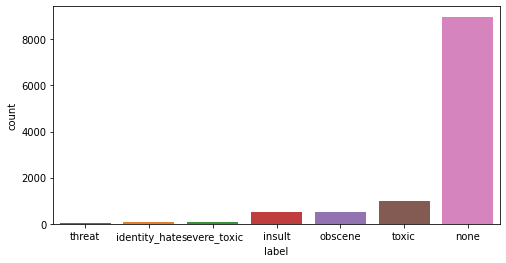

In [164]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
traincomments['none'] = (traincomments['any_category']== 0).astype(int)
COLUMNS.append('none')
df_distribution = traincomments[COLUMNS].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
df_distribution['label']=df_distribution.index
fig = plt.figure()
fig.set_size_inches(8,4)
sns.barplot(x='label', y='count', hue=None, data=df_distribution, order=None, hue_order=None);
df_distribution

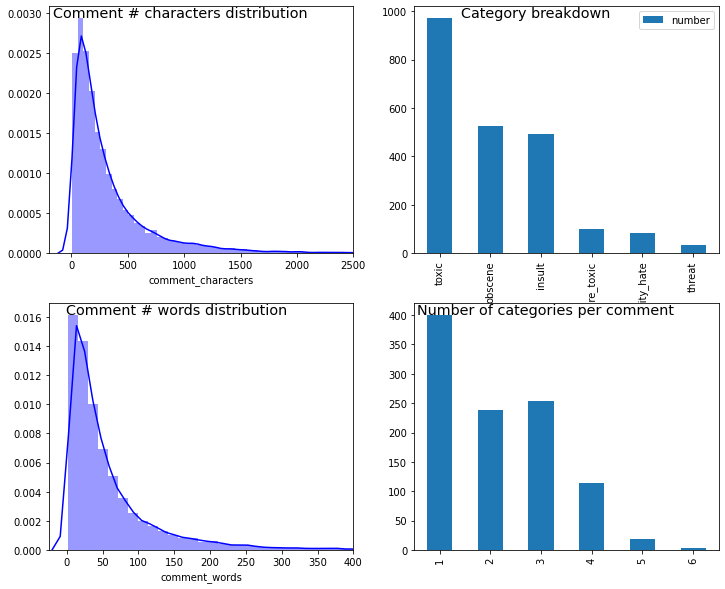

In [137]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.43, y=0.93, ha='center', fontsize='x-large');
ax2.set_title("Category breakdown", x=0.4, y=0.93, ha='center', fontsize='x-large');
ax3.set_title("Comment # words distribution", x=0.42, y=0.93, ha='center', fontsize='x-large');
ax4.set_title("Number of categories per comment", x=0.43, y=0.93, ha='center', fontsize='x-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,2500)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,400)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()


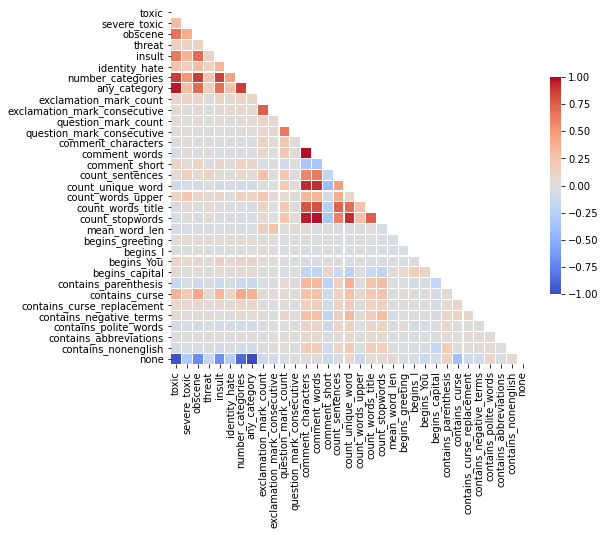

In [138]:
# corr_df = traincomments[traincomments['number_categories']>0]
corr_df = traincomments
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=False, mask=mask, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 7},cmap='coolwarm'); #

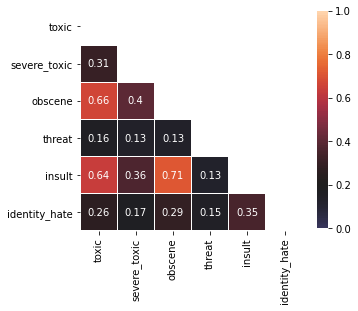

In [139]:
corr_df =traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, mask=mask, vmax=1,vmin=0, center=0.2,
            square=True, linewidths=.2, cbar_kws={"shrink": .8}, annot_kws={"size": 10});

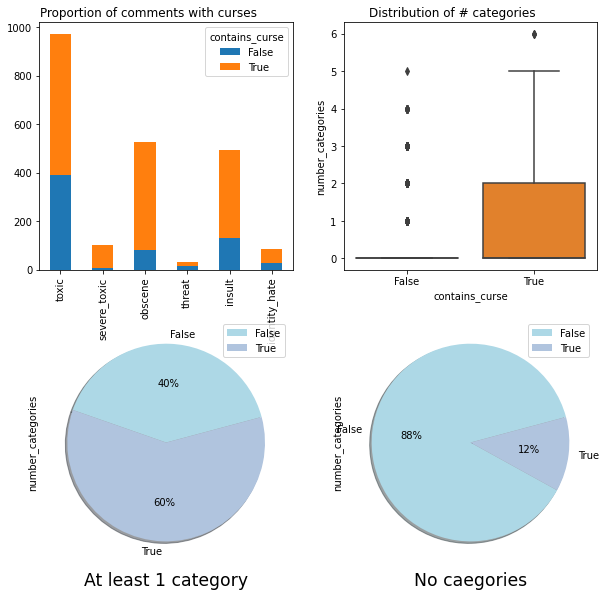

In [140]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.set_size_inches(10,10)
curse_proportion=traincomments.groupby('contains_curse').agg({'toxic':'sum','severe_toxic':'sum','obscene':'sum','threat':'sum','insult':'sum','identity_hate':'sum'}).transpose()
curse_proportion.plot.bar(stacked=True, ax=ax1);
sns.boxplot(x='contains_curse', y='number_categories', hue=None, data=traincomments, order=None, hue_order=None, ax=ax2);
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
traincomments[traincomments['any_category']==1].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax3)
traincomments[traincomments['any_category']==0].groupby('contains_curse').agg({'number_categories':'count'}).plot.pie(y='number_categories',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax4)
ax3.set_title('At least 1 category', x=0.5, y=-0.1, ha='center', fontsize='xx-large');
ax4.set_title('No caegories', x=0.5, y=-0.1, ha='center', fontsize='xx-large');
traincomments[['contains_curse','number_categories']].groupby('contains_curse').describe()

ax1.set_title("Proportion of comments with curses", x=0.43, y=1, ha='center', fontsize='large');
ax2.set_title("Distribution of # categories", x=0.43, y=1, ha='center', fontsize='large');

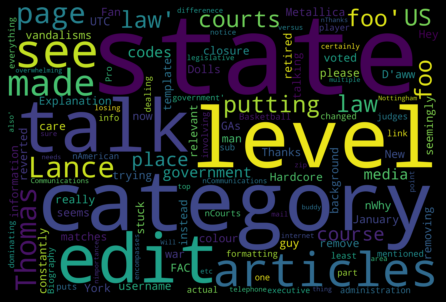

In [141]:
text = traincomments['comment_text'].values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 6), facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Initial Cleanning & Tokenizing**

In [0]:
words_with_numbers_pattern = re.compile(r'\w*[\d]+\w*') # letter\s (0 or more), digit (1 or more), letter\s (0 or more)
special_chars_pattern = re.compile(r'[_,."!?:;=&*\\/()\'$^#]+')
def clean(s):
    s = re.sub(words_with_numbers_pattern, '', s).strip()  # get rid of numbers or words with numbers 
    s = re.sub(special_chars_pattern, '', s)  # remove special chars without removing words
    # ''.join([char.strip(',."!?:;=&*\\/()\'$^#') for char in s])  # remove these characters - this is so slow-- change to re
    return s

In [144]:
traincomments_filtered  = traincomments[(traincomments['comment_words']<300)&(traincomments['comment_characters']<2000)&(traincomments['contains_nonenglish']==False)]
comment_list = traincomments_filtered['comment_text'].values # gives a list of all comments (each is a string)
comment_list_lower=list(map(lambda x:x.lower(),comment_list))
# sentences_list = [re.split('[.\n!?]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
comment_list_lower_splitline = [re.split('[\n]',line) for line in comment_list_lower] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
splitline_flatten = [s for sentence in comment_list_lower_splitline for s in sentence] # gives a list of all sentences (i.e. the comments that we split only by \n)
sentences_list = list(map(lambda x:nltk.sent_tokenize(x),splitline_flatten))
sentences_flat = [s for sentence in sentences_list for s in sentence] # gives a list of all sentences; we loose the comment context
sentences_clean = [clean(s) for s in sentences_flat if len(s) > 1]
words_within_sentences = [s.split() for s in sentences_clean] # list of list; words within sentences
sentences = [words_list for words_list in words_within_sentences if len(words_list)>1] # remove lists with 1 word or less

#remove non-english words
nltk.download('words')
words = set(nltk.corpus.words.words())
#" ".join(w for w in nltk.wordpunct_tokenize(traincomments['comment_text']) \
#         if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## **Word2Vec**

### ***Train Word2Vec Model***

In [145]:
sentences_word2vec = sentences.copy()
word2vec_data = traincomments.copy()
model = Word2Vec(sentences_word2vec, size=100, window=5, min_count=3, workers=4) # train the model
len(model.wv.vocab) #how many words in the vocabulary

8665

### **Word similarity examples**

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


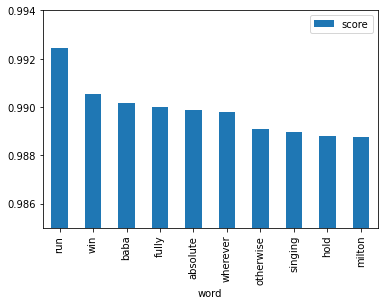

In [146]:
sims=model.wv.most_similar('kill');
sims_df=pd.DataFrame(data=sims, columns=['word','score']);
sims_df.sort_values(by='score',ascending=False).plot.bar('word','score',ylim=(0.985,0.994));

### **Build Word2Vec vocabulary:**

In [147]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()] # build a list of the terms and count
ordered_vocab_sorted = sorted(ordered_vocab, key=lambda k: -k[2]) # sort by the term counts, most common appear first
ordered_terms, term_indices, term_counts = zip(*ordered_vocab_sorted) # unzip the terms, integer indices, and counts into separate lists
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms) # create a DF: vectors (data); terms (index)
word_vectors.sample(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
breeds,-0.058637,0.073453,0.021229,0.018858,0.123925,0.050728,0.004040,0.233564,-0.176474,-0.049595,-0.037749,0.129809,-0.111018,0.010325,-0.021114,0.043634,0.005212,0.038105,-0.175405,0.063056,-0.087172,0.198715,-0.189564,0.068594,0.060772,-0.182536,-0.062377,0.013002,0.123581,-0.032132,0.116116,-0.059587,-0.078128,-0.094485,-0.052282,-0.052419,0.074947,-0.003021,-0.027902,0.084844,...,0.164346,-0.109479,-0.042363,0.180263,0.041938,0.002275,0.015152,0.041856,0.104916,0.038406,0.120697,-0.125067,0.081448,0.005651,-0.096298,-0.123741,-0.051250,0.029455,-0.088839,0.067130,-0.061308,0.016619,0.046411,-0.235794,0.234405,-0.321571,-0.082783,0.044919,-0.007588,-0.234082,0.010361,0.034001,0.034529,0.051682,-0.007068,-0.003517,0.146212,0.008182,0.007622,-0.089851
contributors,-0.012310,0.029201,0.004099,0.023888,0.066031,0.026391,0.030328,0.231657,-0.169995,0.005659,-0.009504,0.173110,-0.136814,0.031373,-0.032898,0.055022,-0.046242,0.014559,-0.151632,0.070021,-0.092658,0.198110,-0.166603,-0.006466,0.056129,-0.108136,-0.078709,0.021092,0.079693,-0.043736,0.063263,-0.078937,-0.108746,-0.130934,-0.051128,0.026846,0.041249,0.020284,-0.027450,0.038077,...,0.139457,-0.141137,-0.041544,0.143278,0.037164,0.000629,0.039949,0.103112,0.141518,0.103441,0.072865,-0.137766,0.048017,-0.013793,-0.064172,-0.154915,-0.103839,0.028593,-0.124192,0.103596,-0.000113,0.046749,-0.022386,-0.280216,0.213907,-0.294041,-0.065829,0.055771,-0.004661,-0.257628,-0.003013,-0.021895,0.063861,0.075908,-0.097882,-0.033310,0.173943,-0.000910,-0.078656,-0.050059
finger,-0.034771,0.034648,0.039301,0.048260,0.137392,0.051058,0.045460,0.247953,-0.191549,-0.007278,-0.020721,0.200297,-0.110877,0.019032,0.008996,-0.007412,-0.017479,0.065416,-0.150714,0.067827,-0.111410,0.206590,-0.149384,0.035225,0.109491,-0.114679,-0.083156,0.007399,0.094258,-0.085224,0.056100,-0.077173,-0.074339,-0.059331,-0.070283,-0.039983,0.070053,0.034361,-0.036671,0.056348,...,0.127302,-0.132365,0.047665,0.129281,0.035460,0.035243,0.021776,0.122343,0.129252,0.074300,0.060123,-0.103237,0.023528,-0.021507,-0.068073,-0.144946,-0.074105,0.002278,-0.078220,0.082568,-0.043423,-0.003695,0.024910,-0.289662,0.178117,-0.298510,-0.050815,0.049091,-0.008269,-0.234501,0.000053,0.003874,0.097408,0.082219,-0.015789,0.003232,0.151789,0.036931,-0.001710,-0.012374
height,-0.048064,0.030139,0.079691,0.047098,0.133641,0.012980,0.018403,0.276377,-0.203421,-0.018605,-0.077371,0.183450,-0.126335,-0.004800,-0.004886,-0.012202,0.027452,0.023258,-0.112796,0.049515,-0.095257,0.160799,-0.163951,0.039930,0.094390,-0.125442,-0.072003,-0.012130,0.053530,-0.037696,0.080334,-0.091414,-0.085779,-0.093913,-0.063606,0.001690,0.055043,0.014540,-0.018351,0.089363,...,0.123784,-0.123556,0.021963,0.124705,0.010457,-0.043114,0.014181,0.061616,0.104028,0.074602,0.038373,-0.120231,0.044558,-0.015483,-0.062619,-0.133794,-0.125978,-0.013915,-0.080274,0.040693,-0.081092,0.006609,0.023635,-0.291695,0.204754,-0.263185,-0.042980,0.089452,0.014101,-0.228286,0.002703,0.014614,0.086545,0.104237,-0.016186,-0.013610,0.153510,0.047059,-0.036356,-0.023074
turn,-0.021130,0.035466,0.016929,-0.000795,0.047715,0.013520,0.012045,0.219897,-0.167402,-0.001978,-0.033961,0.130449,-0.097404,0.047028,-0.030133,0.000982,0.004768,0.040643,-0.122378,0.077923,-0.094208,0.178709,-0.133057,0.036345,0.092482,-0.175557,-0.040653,-0.013240,0.026041,-0.035626,0.103376,-0.065856,-0.099269,-0.065239,-0.029667,0.005991,0.057426,0.042041,0.031207,0.071854,...,0.131045,-0.135016,-0.000793,0.176195,0.037043,0.037833,0.030151,0.087807,0.112186,0.047819,0.109887,-0.108612,0.045449,-0.012780,-0.059121,-0.129940,-0.059943,0.030086,-0.098430,0.088719,-0.045632,0.030420,0.006765,-0.234388,0.246317,-0.377566,-0.073397,0.005408,0.008774,-0.288233,-0.082113,-0.004

## **TSNE**
t-distributed stochastic neighbor embedding

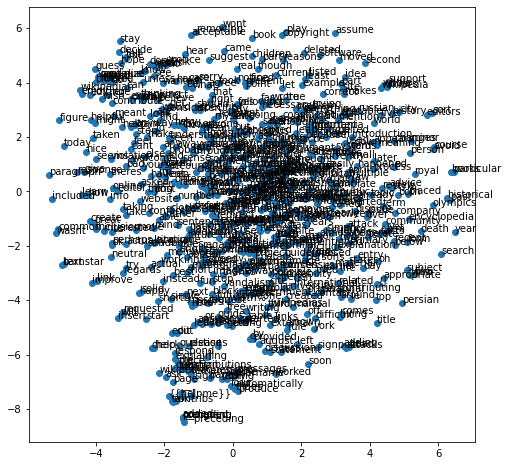

In [0]:
X = word_vectors[:700].to_numpy() # will use top most frequent
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=word_vectors[:700].index.tolist(), columns=['x', 'y'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

### **add vector per comment to training df**
need to clean comment_list before this

In [148]:
wvc=word_vectors.columns.tolist()
cols=word2vec_data.columns.tolist()
cols.extend(wvc)
word2vec_data=word2vec_data.reindex(columns=cols)
for i, comment in enumerate(comment_list):
    org_words = clean(comment).split()
    words = [w for w in org_words if w in word_vectors.index]  #remove words not in model
    comment_vector=word_vectors.loc[words].mean(axis=0)   # average the word vectors for the comment (cum then normalize for word nmber)
    word2vec_data.loc[i, wvc]=comment_vector  # add the features to the df
word2vec_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,contains_nonenglish,none,0,1,2,3,4,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,False,1,-0.027197,0.042581,0.010124,0.041754,0.027210,...,0.092130,-0.133665,0.003122,0.066948,0.030933,-0.002050,0.000136,0.046865,0.073659,0.043912,0.067383,-0.049508,0.008361,0.011509,-0.024192,-0.065892,-0.051045,-0.012169,-0.071825,0.047833,-0.047825,0.009162,-0.008899,-0.234024,0.185018,-0.272999,-0.034555,0.003502,-0.008872,-0.223554,-0.055655,-0.010616,0.066210,0.046474,-0.037270,-0.033607,0.137113,0.024461,-0.044416,-0.032067
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,False,1,-0.022363,0.034794,0.026791,0.038919,0.058955,...,0.110879,-0.119937,0.007301,0.097706,0.010617,-0.026511,0.008755,0.062385,0.081086,0.071441,0.058928,-0.068794,0.010635,0.024640,-0.032032,-0.095155,-0.083440,-0.008500,-0.082892,0.066771,-0.073973,0.016866,-0.008268,-0.246543,0.203640,-0.261095,-0.051559,0.021587,0.014171,-0.218389,-0.031865,0.007706,0.064139,0.058690,-0.037668,-0.008323,0.152335,0.020793,-0.043601,-0.039314
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,False,1,0.013531,0.008336,0.026706,0.004483,0.030204,...,0.098458,-0.073952,-0.013833,0.080188,0.001215,-0.014554,0.001353,0.076252,0.077364,0.047627,0.061348,-0.059996,0.016292,0.013819,-0.022888,-0.073787,-0.047919,0.002188,-0.087674,0.065733,-0.058919,-0.002431,-0.027893,-0.194078,0.174174,-0.264373,-0.043491,0.001236,0.009636,-0.202707,-0.054026,-0.000130,0.062756,0.033668,-0.047749,0.000450,0.158700,-0.003221,-0.039164,-0.027873
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,False,1,-0.015015,0.013116,0.042446,0.010970,0.013443,...,0.121479,-0.096001,-0.022624,0.088754,0.002552,-0.036183,0.006649,0.065038,0.070801,0.050817,0.088554,-0.063047,0.025547,0.010544,-0.007194,-0.069187,-0.056582,-0.003365,-0.085386,0.064232,-0.050566,0.010817,-0.009034,-0.188042,0.182820,-0.253099,-0.048665,0.017727,0.010519,-0.198897,-0.050256,-0.009795,0.057867,0.043361,-0.040479,-0.012080,0.155668,-0.002150,-0.031878,-0.050799
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,False,1,0.023814,0.028844,-0.018518,0.027620,0.013299,...,0.075018,-0.112858,0.010031,0.096008,0.027624,0.034976,0.033322,0.079988,0.095946,0.017359,0.058228,-0.012481,0.032937,-0.006370,-0.017439,-0.076817,-0.041075,-0.004438,-0.069400,0.085650,-0.017597,0.023633,0.005120,-0.186226,0.149705,-0.278677,-0.030003,-0.013501,-0.034272,-0.193332,-0.039730,-0.004954,0.104194,0.046757,-0.072997,0.008076,0.124647,0.033385,-0.004218,-0.013301


# **TF IDF** (Term Frequency – Inverse Document Frequency)

* **Term Frequency**: how often a given word appears within the evaluated text.
* ** Document Frequency**: how often a given word appears within the corpus

TF-IDF highlights words that are more interesting, i.e. frequent in the text but not in the corpus. The higher the TFIDF score, the rarer the term is.

process: 
1. stopword cleanning
2. stemming (go, goes, going = go)/lemmatizing (he,she,it= do)
3. clean "junk"
4. vectorizer (take the corpus and convert each doc/sentence into a sparse matrix of TFIDF)
5. LSA (dimentionality reduction)

###**Cleaning** **preprocessing**

In [0]:
replacement_patterns = [(r'won\'t', 'will not'),(r'can\'t', 'cannot'),(r'i\'m', 'i am'),(r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),(r'(\w+)\'d', '\g<1> would'),] #cleanning:

def strip_symbols(text):
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

class RegexpReplacer(object):
   def __init__(self, patterns=replacement_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
           s = re.sub(pattern, repl, s)
      return s

from nltk.stem import WordNetLemmatizer #stemmig:
lemma = []
wnl = WordNetLemmatizer()
for sen in traincomments['comment_text']:
    tokens = [wnl.lemmatize(w) for w in sen]
    lemma.append(tokens)

# Removing Stopwords
filter_words = []
Stopwords = set(stopwords.words('english'))
Stopwords.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

#ab = spell('nd')
for sent in lemma:
    tokens = [w for w in sent if w not in Stopwords]
    filter_words.append(tokens)

space = ' ' 
for sentence in filter_words:
    sentences.append(space.join(sentence))

replacer=RegexpReplacer()
traincomments.comment_text = traincomments.comment_text.apply(lambda x:replacer.replace(x))
traincomments.comment_text = traincomments.comment_text.apply(lambda x:strip_symbols(x))
traincomments.comment_text = traincomments.comment_text.apply(lambda x:clean(x))



In [166]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words = 'english')  # TFIDF
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(traincomments['comment_text']) # fit_transform
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] # print vectors of 1st comment as example
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) #place tf-idf values in df
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
vandalisms,0.317388
dolls,0.303867
metallica,0.303867
closure,0.280751
hardcore,0.271157
...,...
flyaway,0.000000
flyable,0.000000
fly,0.000000
fluss,0.000000


In [169]:
features= tfidf_vectorizer
features.get_feature_names()[100:110]

['absolutely',
 'absolutewrite',
 'absolutist',
 'absolutly',
 'absorb',
 'absorbed',
 'absorbs',
 'absoultlly',
 'absoutely',
 'abstain']

In [152]:
print(len(features.get_feature_names()))

36052


In [156]:
min_val = 30000
frequent_words = {k:v for k,v in tfidf_vectorizer.vocabulary_.items() if v>min_val}
#list(tfidf_vectorizer.vocabulary_.items())[0:10]
list(frequent_words.items())[0:10]

[('username', 33657),
 ('vandalisms', 33819),
 ('voted', 34281),
 ('york', 35621),
 ('template', 31612),
 ('talk', 31330),
 ('stuck', 30584),
 ('thanks', 31782),
 ('utc', 33699),
 ('trying', 32750)]

### **TF IDF dimensionality reduction: LSA**

In [0]:
# Fit LSA- dimensionality reduction (to 100 features) by means of truncated singular value decomposition (SVD)
lsa = TruncatedSVD(100, algorithm = 'arpack')
lsa = lsa.fit_transform(tfidf_vectorizer_vectors)
lsa

array([[ 0.11234106,  0.01156494,  0.02577666, ...,  0.05143562,
         0.03007977, -0.00536279],
       [ 0.06899584,  0.00379952,  0.00409515, ...,  0.00535534,
        -0.00903233, -0.00275538],
       [ 0.20707305,  0.00592308, -0.05427193, ...,  0.01223262,
         0.01870683, -0.05690747],
       ...,
       [ 0.02279268, -0.01288055, -0.01203431, ...,  0.00184436,
        -0.03308365, -0.00622392],
       [ 0.05788533, -0.0358182 , -0.02444687, ..., -0.03168763,
        -0.00060056, -0.01243711],
       [ 0.01279065, -0.00522084, -0.02098878, ...,  0.00615729,
         0.03573266,  0.05676603]])

Merge the features from TFIDF with the features we created

In [0]:
data = pd.concat([traincomments, pd.DataFrame(lsa)], axis=1)
data_breakpoint = data.copy()
data_breakpoint.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_categories,any_category,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,comment_short,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,begins_greeting,begins_I,begins_You,begins_capital,contains_parenthesis,contains_curse,contains_curse_replacement,contains_negative_terms,contains_polite_words,contains_abbreviations,contains_nonenglish,none,0,1,2,3,4,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,0,0,0,0,1,0,264,43,False,3,41,2,11,18,5.162791,False,False,False,True,False,False,False,True,False,False,True,1,0.112341,0.011565,0.025777,-0.068426,0.045090,...,-0.012211,-0.019684,0.016230,-0.033983,0.006046,0.032535,0.019939,-0.008582,-0.021772,-0.000724,0.026900,-0.011586,-0.020293,-0.011575,0.042599,-0.025192,-0.000071,-0.001467,-0.008524,-0.012010,-0.055548,-0.022493,0.006810,0.013875,0.015601,-0.023380,0.002483,-0.003443,-0.042894,-0.066601,-0.042278,-0.061134,-0.011434,-0.060283,-0.053041,0.013384,-0.020306,0.051436,0.030080,-0.005363
1,000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0,0,0,1,0,0,0,112,17,False,4,17,1,3,2,5.588235,False,False,False,True,True,False,True,False,True,False,True,1,0.068996,0.003800,0.004095,-0.090630,0.055655,...,0.005532,0.001475,0.037626,-0.003924,0.035336,-0.004504,-0.032290,-0.011591,0.018003,0.022912,-0.002571,-0.003227,0.012313,0.008775,-0.002355,-0.000087,0.008685,-0.008663,-0.017836,-0.020460,-0.004130,0.016534,0.018064,0.007765,-0.011208,-0.017850,0.004827,0.002830,-0.006613,-0.007822,-0.006915,0.000075,-0.011228,0.001336,-0.007657,0.004089,0.007654,0.005355,-0.009032,-0.002755
2,000113f07ec002fd,Hey man I m really not trying to edit war It i...,0,0,0,0,0,0,0,0,0,0,0,0,233,42,False,3,39,0,2,20,4.571429,True,False,False,True,False,False,False,False,False,False,True,1,0.207073,0.005923,-0.054272,-0.074055,0.086976,...,0.028393,0.034630,0.002479,0.037009,-0.002683,0.026550,-0.016803,-0.004260,0.012447,-0.024040,-0.001459,0.072508,-0.036881,0.026447,0.013586,-0.007618,-0.012131,-0.014086,-0.026194,-0.005511,-0.095906,-0.023184,0.014212,-0.004654,-0.067008,0.075598,0.002884,-0.025823,0.003669,0.007176,-0.079428,0.097449,0.065572,-0.051642,0.028206,-0.020632,-0.012164,0.012233,0.018707,-0.056907
3,0001b41b1c6bb37e,More I cannot make any real suggestions on im...,0,0,0,0,0,0,0,0,0,0,0,0,622,113,False,4,82,5,7,56,4.486726,False,False,False,False,False,False,False,False,False,False,True,1,0.121315,-0.043943,-0.048371,0.002465,-0.042146,...,0.023159,-0.007075,0.048704,-0.051315,0.017495,0.037723,-0.022168,-0.042273,-0.048758,0.048072,-0.036765,-0.012418,0.093663,-0.017472,0.064183,-0.047396,0.044674,-0.039777,0.000468,0.017606,0.037929,-0.040200,-0.001585,0.059617,-0.027067,-0.014748,-0.034148,0.112670,-0.021099,-0.002989,0.008305,0.027264,-0.008241,-0.024315,0.044156,-0.005702,-0.001954,-0.018314,-0.008507,-0.007646
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,0,0,0,0,1,0,67,13,True,2,13,0,2,5,4.230769,False,False,True,True,False,False,False,False,False,False,True,1,0.081714,0.007300,0.059658,-0.049328,0.041228,...,0.009563,0.014939,0.014923,0.002761,0.003226,-0.011556,0.001323,-0.013142,0.019378,0.012451,0.002471,-0.005048,0.010366,-0.001696,-0.005120,-0.002932,-0.010393,-0.001722,0.007954,0.000375,0.016852,-0.003883,-0.010595,-0.013632,-0.012693,0.015435,-0.008262,0.007489,-0.009574,-0.005790,-0.005821,-0.006673,0.013990,-0.003721,-0.020211,0.004889,-0.001454,-0.010064,-0.008074,-0.002801


Prepare the data

In [0]:
X = data_breakpoint.drop('comment_text', axis=1)
y = data_breakpoint.comment_text

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    test_size=0.25,
                                                    shuffle=True, 
                                                    )

#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    train_size=0.75, 
#                                                    test_size=0.25,
#                                                    shuffle=True, 
#                                                    stratify=traincomments.comment_text)

Feature selection

In [0]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
#select numaries features
num_X = X.select_dtypes(include=[np.number])
num_X = num_X.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'number_categories', 'any_category', 'none'])
num_X.head()

,identity_hate,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0,0,1,0,264,43,3,41,2,11,18,5.162791,0.112341,0.011565,0.025777,-0.068426,0.045090,0.013306,-0.053556,0.013793,-0.000339,-0.015744,-0.025293,0.006975,0.011841,-0.017604,0.017374,-0.037681,0.019164,0.054383,0.020496,-0.048597,0.029098,-0.015473,-0.010906,0.002932,-0.052284,0.021930,0.011443,...,-0.012211,-0.019684,0.016230,-0.033983,0.006046,0.032535,0.019939,-0.008582,-0.021772,-0.000724,0.026900,-0.011586,-0.020293,-0.011575,0.042599,-0.025192,-0.000071,-0.001467,-0.008524,-0.012010,-0.055548,-0.022493,0.006810,0.013875,0.015601,-0.023380,0.002483,-0.003443,-0.042894,-0.066601,-0.042278,-0.061134,-0.011434,-0.060283,-0.053041,0.013384,-0.020306,0.051436,0.030080,-0.005363
1,0,1,0,0,0,112,17,4,17,1,3,2,5.588235,0.068996,0.003800,0.004095,-0.090630,0.055655,0.055462,0.106795,0.036353,-0.013745,-0.008623,0.061636,0.018909,0.167248,-0.008086,-0.032968,-0.011316,0.003165,0.005476,-0.004494,-0.010309,-0.004990,0.000157,0.000568,-0.000634,0.000743,-0.011661,0.003748,...,0.005532,0.001475,0.037626,-0.003924,0.035336,-0.004504,-0.032290,-0.011591,0.018003,0.022912,-0.002571,-0.003227,0.012313,0.008775,-0.002355,-0.000087,0.008685,-0.008663,-0.017836,-0.020460,-0.004130,0.016534,0.018064,0.007765,-0.011208,-0.017850,0.004827,0.002830,-0.006613,-0.007822,-0.006915,0.000075,-0.011228,0.001336,-0.007657,0.004089,0.007654,0.005355,-0.009032,-0.002755
2,0,0,0,0,0,233,42,3,39,0,2,20,4.571429,0.207073,0.005923,-0.054272,-0.074055,0.086976,0.014297,-0.092545,-0.004326,0.003307,-0.004423,-0.057379,-0.021490,-0.028514,-0.040156,0.011921,-0.099312,0.057121,0.095206,-0.042853,-0.122485,-0.028768,-0.023728,-0.033679,0.019984,-0.014362,0.036551,0.019997,...,0.028393,0.034630,0.002479,0.037009,-0.002683,0.026550,-0.016803,-0.004260,0.012447,-0.024040,-0.001459,0.072508,-0.036881,0.026447,0.013586,-0.007618,-0.012131,-0.014086,-0.026194,-0.005511,-0.095906,-0.023184,0.014212,-0.004654,-0.067008,0.075598,0.002884,-0.025823,0.003669,0.007176,-0.079428,0.097449,0.065572,-0.051642,0.028206,-0.020632,-0.012164,0.012233,0.018707,-0.056907
3,0,0,0,0,0,622,113,4,82,5,7,56,4.486726,0.121315,-0.043943,-0.048371,0.002465,-0.042146,-0.037073,0.018077,-0.029397,0.011914,-0.033328,0.006656,0.027716,-0.015196,0.018771,-0.042227,0.018905,-0.013967,0.000579,0.036982,-0.001393,-0.056676,-0.011493,-0.029505,0.075249,0.002869,0.019195,-0.028571,...,0.023159,-0.007075,0.048704,-0.051315,0.017495,0.037723,-0.022168,-0.042273,-0.048758,0.048072,-0.036765,-0.012418,0.093663,-0.017472,0.064183,-0.047396,0.044674,-0.039777,0.000468,0.017606,0.037929,-0.040200,-0.001585,0.059617,-0.027067,-0.014748,-0.034148,0.112670,-0.021099,-0.002989,0.008305,0.027264,-0.008241,-0.024315,0.044156,-0.005702,-0.001954,-0.018314,-0.008507,-0.007646
4,0,0,0,1,0,67,13,2,13,0,2,5,4.230769,0.081714,0.007300,0.059658,-0.049328,0.041228,0.015791,-0.058106,0.006520,0.028703,0.018145,-0.121626,-0.049597,0.019635,0.071290,0.024211,0.002583,0.011740,0.005737,-0.011609,0.020269,-0.011397,-0.026392,-0.001776,-0.012174,-0.000625,0.000749,0.009390,...,0.009563,0.014939,0.014923,0.002761,0.003226,-0.011556,0.001323,-0.013142,0.019378,0.012451,0.002471,-0.005048,0.010366,-0.001696,-0.005120,-0.002932,-0.010393,-0.001722,0.007954,0.000375,0.016852,-0.003883,-0.010595,-0.013632,-0.012693,0.015435,-0.008262,0.007489,-0.009574,-0.005790,-0.005821,-0.006673,0.013990,-0.003721,-0.020211,0.004889,-0.001454,-0.010064,-0.008074,-0.002801


In [0]:
# VarianceThreshold transformer
selector = VarianceThreshold(0.1)
selector.fit(num_X)
new_columns = num_X.columns[selector.get_support()]
new_num_X = num_X[new_columns]
new_num_X.head()

,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0,0,1,0,264,43,3,41,2,11,18,5.162791
1,1,0,0,0,112,17,4,17,1,3,2,5.588235
2,0,0,0,0,233,42,3,39,0,2,20,4.571429
3,0,0,0,0,622,113,4,82,5,7,56,4.486726
4,0,0,1,0,67,13,2,13,0,2,5,4.230769


In [0]:
#select KBest transformer
new_num_X_selector = SelectKBest(score_func=f_classif, k=5)

In [0]:
X_train_num_reduced = \
    pd.DataFrame(new_num_X_selector.fit_transform(new_num_X, y_train), 
                 columns=new_num_X_selector.columns[new_num_X.get_support()].values)
X_train_num_reduced.head()

In [0]:
#select KBest on TFIDF features
X_train_tfidf = X_train.loc[:, range(0,100)]
tfidf_selector = SelectKBest(score_func=f_classif, k=6)

In [0]:
X_train_tfidf_reduced = \
    pd.DataFrame(tfidf_selector.fit_transform(X_train_tfidf, y_train), 
                 columns=X_train_tfidf.columns[tfidf_selector.get_support()].values)
X_train_tfidf_reduced.head()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,94,95,96,97,98,99
0,-0.008190,0.004469,0.017504,-0.014646,-0.014382,-0.000175
1,0.002430,0.016356,0.019791,0.006224,-0.003598,0.006454
2,0.057784,-0.004685,-0.054175,-0.013524,-0.004852,-0.056220
3,-0.020679,-0.019442,0.021666,-0.011500,0.005279,-0.006837
4,-0.015711,0.004180,-0.023002,-0.017982,0.009027,0.004666


In [0]:
X_processed = pd.concat([X_train_tfidf_reduced, pd.DataFrame(new_num_X)], axis=1)
X_processed.head()

,94,95,96,97,98,99,exclamation_mark_count,exclamation_mark_consecutive,question_mark_count,question_mark_consecutive,comment_characters,comment_words,count_sentences,count_unique_word,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,-0.008190,0.004469,0.017504,-0.014646,-0.014382,-0.000175,0,0,1,0,264,43,3,41,2,11,18,5.162791
1,0.002430,0.016356,0.019791,0.006224,-0.003598,0.006454,1,0,0,0,112,17,4,17,1,3,2,5.588235
2,0.057784,-0.004685,-0.054175,-0.013524,-0.004852,-0.056220,0,0,0,0,233,42,3,39,0,2,20,4.571429
3,-0.020679,-0.019442,0.021666,-0.011500,0.005279,-0.006837,0,0,0,0,622,113,4,82,5,7,56,4.486726
4,-0.015711,0.004180,-0.023002,-0.017982,0.009027,0.004666,0,0,1,0,67,13,2,13,0,2,5,4.230769


# OneVsRest
Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
categories = traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
# Training logistic regression model on train data
LogReg_pipeline.fit_predict((X_processed, y_train))


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
categories = traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

classifier = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)
classifier_pred = classifier.fit(X_processed, y_train).predict(X_processed)

In [0]:
classifier_pred.predict_proba(X_processed)

In [0]:
classifier_pred.get_params(X_processed)